In [1]:
import pickle
import pandas as pd
from datetime import timedelta, datetime
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
import gc
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from copy import copy, deepcopy
import requests
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import scipy.stats as sts
import numpy as np
from sklearn.linear_model import LinearRegression
from IPython.display import Image, display

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

###  1 Dowloading and preprocessing data

_Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
- _взять в тренировочный набор турниры с dateStart из 2019 года;_
- _в тестовый — турниры с dateStart из 2020 года._


In [2]:
with open('chgk/players.pkl', 'rb') as f:
    chgk_players = pickle.load(f)
    
with open('chgk/results.pkl', 'rb') as f:
    results = pickle.load(f)
    
with open('chgk/tournaments.pkl', 'rb') as f:
    tournaments = pickle.load(f)    

In [3]:
def preprocess_results(results:dict,tournaments:dict,start_time:str, end_time:str):
    allowed = {'1','0'}
    out = []
    start_time_date = datetime.strptime(start_time, '%Y-%m-%d')
    end_time_date = datetime.strptime(end_time, '%Y-%m-%d')
    
    for key in tournaments.keys():
        tournament_date  =  datetime.fromisoformat(tournaments[key]['dateStart']).replace(tzinfo=None)
        
        if tournament_date >= start_time_date and tournament_date < end_time_date:
            
            if not results[key] or not [team for team in results[key] if team.get('mask') is None or allowed.issuperset(team.get('mask'))] :
                continue
            
            if len(set([len(team['mask']) for team in results[key] if team.get('mask') is not None])) > 1:
                continue
            
            tournament = {
                'id':tournaments[key]['id'],
                'teams':[]
            }

            for team in results[key]:
                if team.get('mask') is None or not allowed.issuperset(team.get('mask')):
                    continue
                if team['mask']:
                    team_information = {
                        'id': team['team']['id'],
                        'mask': team['mask'],
                        'players': [member['player']['id'] for member in team['teamMembers']]
                    }

                    tournament['teams'].append(team_information)
            if tournament['teams']:       
                out.append(tournament)  
    return out

In [4]:
train = preprocess_results(results,tournaments,'2019-01-01','2020-01-01')
validation = preprocess_results(results,tournaments,'2020-01-01','2021-01-01')

Подчистим наши данные из памяти 

In [7]:
del results
gc.collect()

66

Проведем анализ данных “Что? Где? Когда?” (ЧГК)

In [8]:
teams_in_tournaments = []
questions = []
players = defaultdict(set)
ration_correct_answers = []
questions = []
questions_raito = []


for tournament in train:
    
    answers_in_tournament = []
    teams_in_tournaments.append(len(tournament['teams']))
    
    for team in tournament['teams']:
        
        for player in team['players']:
            players[player].add(tournament['id'])
        
        
        team_answers = list(map(int, team['mask']))
        team_questions = len(team_answers)
        correct_answers = sum(team_answers)
        ration_correct_answers.append(sum(team_answers) / team_questions)
        answers_in_tournament.append(team_answers)
    

    questions.append(team_questions)  
    questions_raito += np.array(answers_in_tournament).mean(axis=0).tolist()

In [9]:
pd.DataFrame(teams_in_tournaments,columns=['Статистика команд на турнирах ЧГК']).describe()

,Статистика команд на турнирах ЧГК
count,604.000000
mean,110.231788
std,170.291602
min,1.000000
25%,22.000000
50%,44.500000
75%,122.500000
max,1218.000000


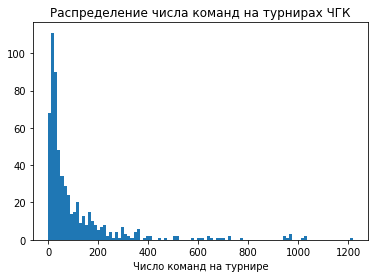

In [10]:
plt.title('Распределение числа команд на турнирах ЧГК')
plt.hist(teams_in_tournaments, bins=100)
plt.xlabel('Число команд на турнире')
plt.show()

In [11]:
pd.DataFrame(questions,columns=['Вопросы ЧГК']).describe()

,Вопросы ЧГК
count,604.000000
mean,46.794702
std,29.956977
min,23.000000
25%,36.000000
50%,36.000000
75%,45.000000
max,500.000000


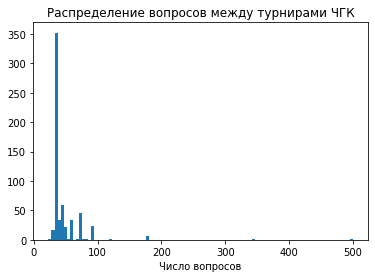

In [12]:
plt.title('Распределение вопросов между турнирами ЧГК')
plt.hist(questions, bins=100)
plt.xlabel('Число вопросов')
plt.show()

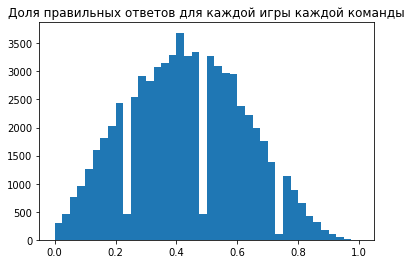

In [13]:
plt.hist(ration_correct_answers, bins=40)
plt.title('Доля правильных ответов для каждой игры каждой команды')
plt.show();

In [14]:
pd.DataFrame(ration_correct_answers,columns=['Статистики доли правильных ответов на турнирах ЧГК']).describe()

,Статистики доли правильных ответов на турнирах ЧГК
count,66580.000000
mean,0.428877
std,0.191962
min,0.000000
25%,0.277778
50%,0.416667
75%,0.566667
max,1.000000


In [15]:
players_answers = defaultdict(int)
players = set()
players_true_answers = defaultdict(int)

for tournament in train:
    for team in tournament['teams']:
        for player in team['players']:
            players_answers[player] += len(team['mask'])
            players_true_answers[player] = sum(list(map(int, team['mask'])))
            players.add(player)

Кодируем игроков, чтобы развернуть в вектор для обучения модели

In [16]:
player_to_index = {player:index for index, player in enumerate(players)}
index_to_player = {index:player for player, index in player_to_index.items()}

### 2 Baseline 
_Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:_
- _повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;_
- _в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;_
- _для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков._


Кодируем юзеров и  вопросы турниров ЧГК (one hot) и вытягиваем в вектор. В качестве ответов для модели будем использовать ответы игроков на вопросы. Так как у нас в бинарый ответ(target), то мы будем использовать модель классификации (LogisticRegression)  для Baseline решения. 
Для оценки силы игроков будем использовать коэфициенты модели

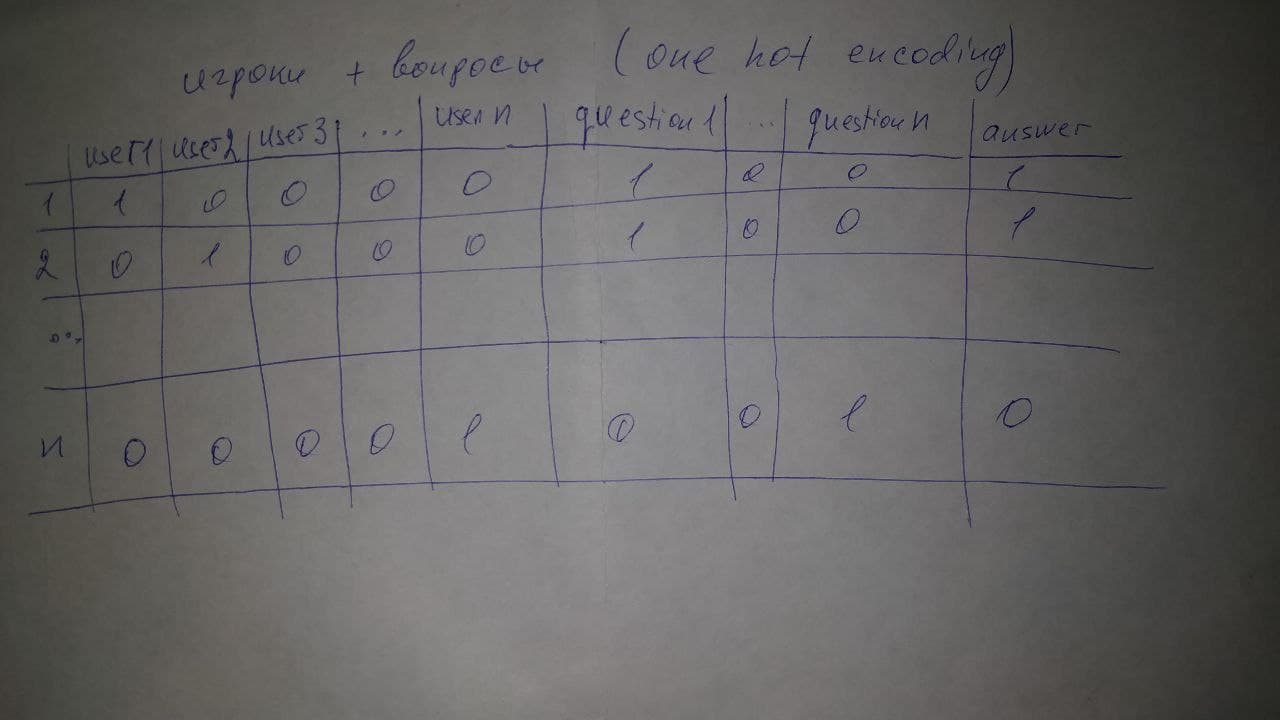

In [82]:
display(Image(filename='images/image_1.jpg', embed=True))

In [64]:
team_ids = []
question_idxs = []
answers_target = []
player_questions_count = []
players_idxs =[]

questions_count = 0
for tournament in train:
    tournament_questions = len(tournament['teams'][0]['mask'])
    for team in tournament['teams']:
        team_answers = list(map(int, team['mask']))
        for question in range(tournament_questions):
            for player in team['players']:
                players_idxs.append(player_to_index[player])
                question_idxs.append(len(player_to_index) + questions_count + question)
                team_ids.append(team['id'])
                answers_target.append(team_answers[question])
    questions_count += tournament_questions
    
shape_matrix_columns , shape_matrix_rows = len(players_idxs) + questions_count , len(players_idxs)
X = sparse.lil_matrix((shape_matrix_rows, shape_matrix_columns),  dtype=int)

# set init value 
X[range(len(players_idxs)), players_idxs] = 1
X[range(len(players_idxs)), question_idxs] = 1

_, dim1 = X.shape 

y = np.array(answers_target)

In [18]:
log_regression_model = LogisticRegression(tol=1e-2, solver='saga',n_jobs=-1)

In [19]:
log_regression_model.fit(X, y)

LogisticRegression(n_jobs=-1, solver='saga', tol=0.01)

In [20]:
player_powers = log_regression_model.coef_[0]

In [21]:
question_rating = player_powers[len(player_to_index):]
rating = player_powers[:len(player_to_index)]
players_raiting = []
for index, player in index_to_player.items():
    players_raiting.append({
        'id': player,
        'power': rating[index],
        'name': chgk_players[player]['name'] + ' ' + chgk_players[player]['surname'],
        'questions': players_answers[player],
    })
    
players_raiting = sorted(players_raiting, key=lambda x: x['power'], reverse=True)

In [22]:
def player_position(player_id):
    try:
        return int(requests.get(f'https://rating.chgk.info/api/players/{player_id}/rating/last').json()['rating_position'])
    except Exception:
        return -100

In [51]:
rating_score_df = pd.DataFrame(players_raiting)[:60]
rating_score_df['player_position'] = rating_score_df['id'].apply(player_position)
rating_score_df['questions'] = rating_score_df['id'].apply(lambda x: players_answers[x])
rating_score_df.head(20)

,id,power,name,questions,player_position
0,27403,4.068340,Максим Руссо,1796,5
1,4270,3.932395,Александра Брутер,2240,6
2,28751,3.885699,Иван Семушин,3071,3
3,27822,3.852908,Михаил Савченков,2666,2
4,30270,3.758144,Сергей Спешков,3017,4
5,30152,3.753011,Артём Сорожкин,4006,1
6,18036,3.619152,Михаил Левандовский,1113,8
7,20691,3.614247,Станислав Мереминский,1370,38
8,87637,3.542323,Антон Саксонов,927,158
9,22799,3.539431,Сергей Николенко,1806,10


In [53]:
intersection = rating_score_df[rating_score_df['player_position'] <= 60]
intersection.shape[0]

32

Baseline модель опеделила 32 игрока ЧГК из top-60, что есть неплохо :) 

### 3 Quality of the rating system
_Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:_
- _предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;_
- _в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров._


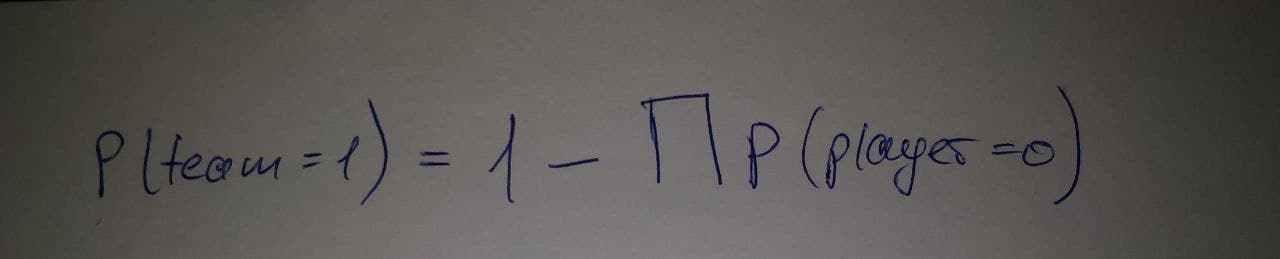

In [34]:
display(Image(filename='images/image_2.jpg', embed=True))

Для оценки качетва райтинг системы будем прогнозировать ответ вопроса (автрактного) с учетом ответа каждого игрока в команде

In [25]:
validation_rating = []
tournaments_validation = []

for tournament in validation:
    teams_validation = []
    teams_rating = []
    for team in tournament['teams']:
  
        players = [p for p in team['players'] if p in player_to_index.keys()]
        team_test = copy(team)
        team_test['players'] = players
        
        if len(players) > 0:
            teams_validation.append(team_test)
            teams_rating.append(sum(list(map(int, team['mask']))))
     
    if len(teams_validation) > 1:
        tournament_val = copy(tournament)
        tournament_val['teams'] = teams_validation
        tournaments_validation.append(tournament_val)
        validation_rating.append(teams_rating)

In [26]:
def predict_tournaments(model, tournaments, player_to_index):
    rating_predictions = []
    for torunament in tournaments:
        predictions = []
        for team in torunament['teams']:
            player_idxs = [player_to_index[p] for p in team['players']]
            player_number = len(player_idxs)
            
            X = sparse.lil_matrix((len(player_idxs), dim1), dtype=int)
            X[range(len(player_idxs)), player_idxs] = 1
            
            predictions.append(1 - model.predict_proba(X)[:, 0].prod())

        rating_predictions.append(predictions)
    return rating_predictions

In [27]:
def calculate_spearman_correlations(target, predict):
    output = []
    for i in range(len(target)):
        spearman = sts.spearmanr(target[i], predict[i]).correlation
        output.append(spearman)
    return np.mean(output)
        
def calculate_kendall_correlations(target, predict):
    output = []
    for i in range(len(target)):
        kendall = sts.kendalltau(target[i], predict[i]).correlation
        output.append(kendall)
    return np.mean(output)    

In [28]:
reting_prediction = predict_tournaments(log_regression_model,tournaments_validation, player_to_index)

spearman_correlation = calculate_spearman_correlations(validation_rating, reting_prediction)
kendall_correlation = calculate_kendall_correlations(validation_rating, reting_prediction)

print(f'Spearman correlation : {spearman_correlation}\nKendall correlation : {kendall_correlation}')

Spearman correlation : 0.8024169662590201
Kendall correlation : 0.64464491999789


### 4 EM algorithm
Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
- предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
- разработайте EM-схему для обучения этой модели, реализуйте её в коде;
- обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.


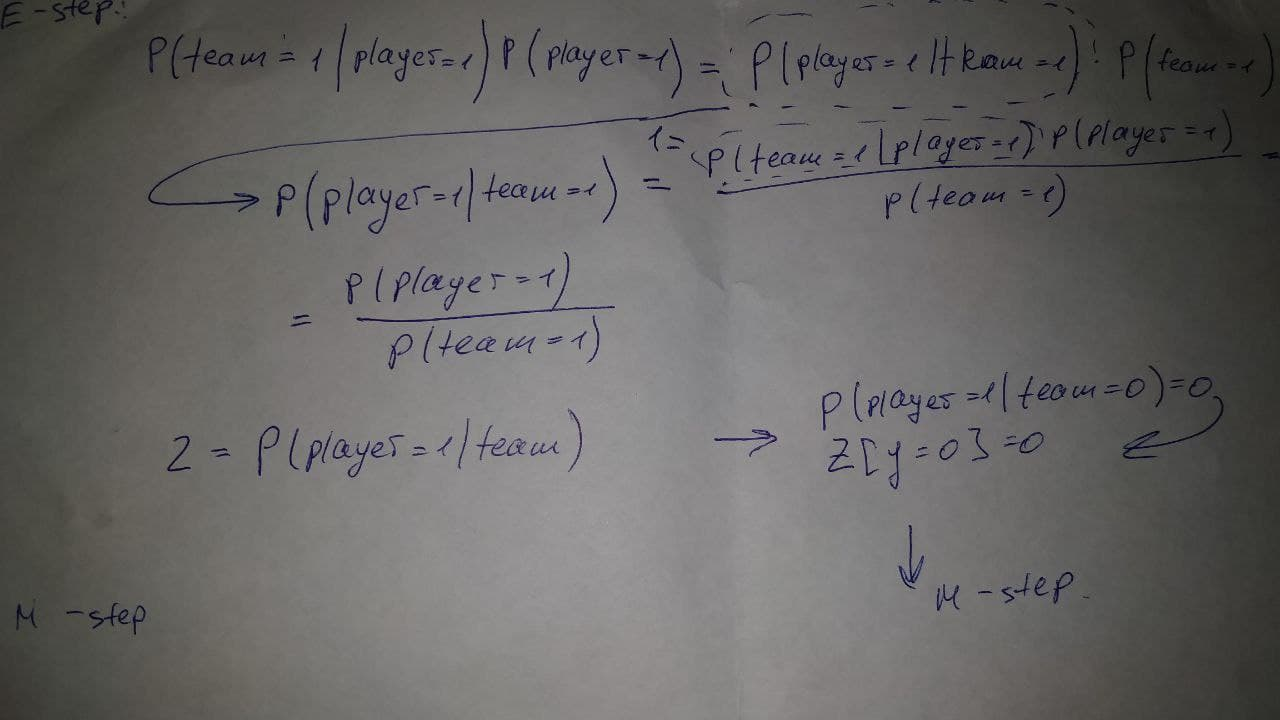

In [41]:
display(Image(filename='images/image_3.jpg', embed=True))

На шаге Е мы предсказываем вероятность каждого игрока на определенный вопрос при условии команды и это будут скрытые переменные EM алгоритма.  На шаге M обучаем модель на скрытых параметрах.
Для обучения вероятностей воспользуемся LinearRegression и немного преобразуем модель , чтобы значения лежали между 0 и 1 y ∈ (0,1). На [stackoverflow](https://stackoverflow.com/questions/44234682/how-to-use-sklearn-when-target-variable-is-a-proportion) есть отличный пост как обучать такие модели и попробуем воспользоваться советами из этого поста.

In [29]:
class ProbabilityLogitRegression(LinearRegression):

    def fit(self, x, p):
        p = np.asarray(p)
        y = np.log(p /(1 - p))
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x)
        return 1 / (np.exp(-y) + 1)
    def predict_proba(self, x):
        y = super().predict(x)
        y = 1 / (np.exp(-y) + 1)
        return np.hstack(((1 - y).reshape(-1, 1), y.reshape(-1, 1)))

In [30]:
EPS = 1e-5

def e_step(X, model):
    prediction = model.predict_proba(X)
  
    playes_df = pd.DataFrame({'team': team_ids, 'question': question_idxs, 'player_fail_proba': prediction[:, 0], 'player_success_proba': prediction[:, 1]})
    
    team_df = playes_df.groupby(['team', 'question']).agg({'player_fail_proba': np.prod}).reset_index()
    team_df.rename(columns={'player_fail_proba':'team_fail_proba'}, inplace=True)
    team_df['team_success_proba'] = 1 - team_df['team_fail_proba']
    team_df  = team_df[['team','question','team_success_proba']]
    
    playes_df = pd.merge(playes_df, team_df, left_on=['team', 'question'],  right_on=['team', 'question'])
    
    z = (playes_df['player_success_proba'] / playes_df['team_success_proba']).clip(EPS, 1-EPS)
    z[y == 0] = EPS
    
    return z

def m_step(X,z,model):
    model.fit(X,z)

Зададим начальное состояние EM алгоритма, подготовим наши правильные ответы (бинарные ответы) для регрессии y ∈ (0,1) и обучим модель

In [31]:
model = ProbabilityLogitRegression(n_jobs=-1)

#подготовим наши правильные ответы (бинарные ответы) для регрессии y ∈ (0,1)
y_eps = y.astype(np.float32)
y_eps[y_eps==0.] = EPS
y_eps[y_eps==1.] = 1-EPS

#обучим модель
model.fit(X, y_eps)


ProbabilityLogitRegression(n_jobs=-1)

In [32]:
reting_prediction = predict_tournaments(model,tournaments_validation, player_to_index)

spearman_correlation = calculate_spearman_correlations(validation_rating, reting_prediction)
kendall_correlation = calculate_kendall_correlations(validation_rating, reting_prediction)

print(f'Spearman correlation : {spearman_correlation}\nKendall correlation : {kendall_correlation}')

Spearman correlation : 0.8005975155553602
Kendall correlation : 0.640747490124936


In [33]:
for step in range(10):
    
    print(f'Step : {step + 1}')
    
    z = e_step(X, model)
    
    m_step(X,z,model)
    
    reting_prediction = predict_tournaments(model,tournaments_validation, player_to_index)
    
    spearman_correlation = calculate_spearman_correlations(validation_rating,reting_prediction)
    kendall_correlation = calculate_kendall_correlations(validation_rating, reting_prediction)

    print(f'Spearman correlation : {spearman_correlation}\nKendall correlation : {kendall_correlation}\n')

Step : 1
Spearman correlation : 0.8001105177971716
Kendall correlation : 0.6430020064571214

Step : 2
Spearman correlation : 0.80607217344991
Kendall correlation : 0.6500412854150835

Step : 3
Spearman correlation : 0.8103635254287054
Kendall correlation : 0.6553494633296175

Step : 4
Spearman correlation : 0.8085868311835952
Kendall correlation : 0.6532591170251093

Step : 5
Spearman correlation : 0.8092169625942536
Kendall correlation : 0.6537609171520469

Step : 6
Spearman correlation : 0.8097843352127951
Kendall correlation : 0.6544676798961447

Step : 7
Spearman correlation : 0.809753379484255
Kendall correlation : 0.654624054142814

Step : 8
Spearman correlation : 0.8092023881596568
Kendall correlation : 0.6540510480491422

Step : 9
Spearman correlation : 0.8090364911704798
Kendall correlation : 0.6538012071142852

Step : 10
Spearman correlation : 0.809024445627744
Kendall correlation : 0.6537515586648184



In [54]:
question_rating = model.coef_[len(player_to_index):]
rating = model.coef_[:len(player_to_index):]
rating_em = []
for idx, player in index_to_player.items():
    rating_em.append({
        'power': rating[idx],
        'id': player,
        'name': chgk_players[player]['name'] + ' ' + chgk_players[player]['surname'],
        'questions': players_answers[player],
    })
    
rating_em = sorted(rating_em, key=lambda x: x['power'], reverse=True)

In [55]:
rating_em_df = pd.DataFrame(rating_em)[:60]
rating_em_df['player_position'] = rating_em_df['id'].apply(player_position)
rating_em_df['questions'] = rating_em_df['id'].apply(lambda x: players_answers[x])
rating_em_df.head(20)

,power,id,name,questions,player_position
0,14.990128,38175,Максим Пилипенко,36,9953
1,14.588536,199963,Елена Бровченко,36,-100
2,13.782788,135951,Артём Стетой,36,-100
3,13.528362,133504,София Лебедева,36,-100
4,13.442243,121433,София Савенко,36,20735
5,13.204534,100134,Алина Бауэр,36,8124
6,12.938721,14996,Ольга Козлова,36,14904
7,11.896983,163668,Георгий Титов,36,-100
8,11.783121,54509,Святослав Маленький,36,6690
9,11.769404,22474,Илья Немец,75,4475


In [38]:
intersection_em = rating_em_df[rating_em_df['player_position'] <= 60]
intersection_em.shape[0]


26

Как было сказано,что появится много ноунеймов и один способов отранджировать является отфильтровать рейтинг по числу вопросов.

In [47]:
rating_em_filtered_df = pd.DataFrame(rating_em)
rating_em_filtered_df = rating_em_filtered_df[rating_em_filtered_df.questions > 1500][:60].reset_index()
rating_em_filtered_df['player_position'] = rating_em_filtered_df['id'].apply(player_position)
rating_em_filtered_df['questions'] = rating_em_filtered_df['id'].apply(lambda x: players_answers[x])
rating_em_filtered_df.head(20)

,index,power,id,name,questions,player_position
0,66,8.062972,27403,Максим Руссо,1796,5
1,68,7.989070,7008,Алексей Гилёв,3493,30
2,72,7.892351,30152,Артём Сорожкин,4006,1
3,86,7.641477,27822,Михаил Савченков,2666,2
4,95,7.508099,4270,Александра Брутер,2240,6
5,96,7.486941,28751,Иван Семушин,3071,3
6,97,7.478501,18332,Александр Либер,2937,7
7,119,7.167792,16837,Наталья Кудряшова,2147,23
8,120,7.156876,30270,Сергей Спешков,3017,4
9,123,7.122145,6212,Юрий Выменец,2644,12


In [48]:
intersection_em = rating_em_filtered_df[rating_em_filtered_df['player_position'] <= 60]
intersection_em.shape[0]

32

Метрики росли медленно для EM алгоритма, но  позволил улучшить рейтинг систему 

### 5 Quations rating
_А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету)._


Как мы определяли силу участников ЧГК через коэффициенты модели также поступим и с определением сложности вопросов questionsс учетом сдвига, когда начинаются вопросы в исходной матрице (players+questions)

In [58]:
rating_tournament = dict()
question_idx_from = 1 + len(player_to_index)
rating_qutions = model.coef_[question_idx_from:]

offset_questions = 0
for tournament in train:
    questions_in_tournament = len(tournament['teams'][0]['mask'])
    
    from_question_index = offset_questions
    to_question_index = from_question_index + questions_in_tournament
    offset_questions += questions_in_tournament
    
    rating_tournament[tournament['id']] = np.mean(rating_qutions[from_question_index: to_question_index])
    
rating_tournament = sorted(rating_tournament.items(), key=lambda x: x[1])

tournament_rating_df = pd.DataFrame([t[0] for t in rating_tournament], columns=['id'])
tournament_rating_df['name'] = tournament_rating_df['id'].apply(lambda x: tournaments[x]['name'])

In [62]:
tournament_rating_df.head(20)

,id,name
0,6149,Чемпионат Санкт-Петербурга. Первая лига
1,5928,Угрюмый Ёрш
2,5942,Чемпионат Мира. Этап 2. Группа В
3,5159,Первенство правого полушария
4,5465,Чемпионат России
5,5941,Чемпионат Мира. Этап 2. Группа А
6,5946,Чемпионат Мира. Этап 3. Группа В
7,5083,Ускользающая сова
8,5693,Знание – Сила VI
9,5587,Записки охотника


In [61]:
tournament_rating_df.tail(20)

,id,name
584,5593,Межфакультетский кубок МГУ. Отбор №3
585,5697,Школьный Синхрон-lite. Выпуск 3.1
586,5313,(а)Синхрон-lite. Лига старта. Эпизод VI
587,5876,(А) Славянка без раздаток. 4 этап
588,5009,(а)Синхрон-lite. Лига старта. Эпизод III
589,5388,Олимпиада Приволжского федерального округа. Финал
590,5954,Школьная лига. II тур.
591,5936,Школьная лига. I тур.
592,5698,(а)Синхрон-lite. Лига старта. Эпизод VII
593,5702,(а)Синхрон-lite. Лига старта. Эпизод IX


Как мы видем мы смогли отранджировать турниры по сложности вопросов и в топ по сложности вопросов попадают международные турниры ЧГК, а внизу списка региональнеы и школьные турниры.